# Content list - PART 2
### Import libraries and data
### Geographical spending habits
Regional segmentation

Spending habits
### Customer profiling
Profiling based on family status

Profiling based on income
### Descriptive stats based on customer profiles
QUESTION: is the number of days between orders influenced by the customer's family profile? income group? region?

QUESTION: is the hour of the day where orders are placed influenced by the customer's family profile? income group? region?

QUESTION: Is the type of goods (department_id) influenced by the customer's family profile? income group? region?

QUESTION: Is the price of the products ordered influenced by the customer's family profile? income group? region?

QUESTION: Is the average total price of the orders influenced by the customer's family profile? income group? region?

# Import libraries and data

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importing data
#create path
path = r'C:\Users\Mathilde\Documents\DATA ANALYSIS CAREERFOUNDRY\May 2024 - Instacart Basket Analysis'
#final merged data set with only active customers
df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared data', 'ords_prods_merge_high_activ_cx.pkl'))

Note: From the previous notebook named "Task 4.10 Part 1" I only managed to export a data frame from which I dropped the low activity cutsomers, but with no greographic segmentation (due to memory error).
Let's add the geographic segmentation now:

# Geographical spending habits

## Regional segmentation

In [3]:
# Check name of columns
pd.options.display.max_columns = None
df.head(1)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,prices,price_range_loc,busiest_day,busiest_period_of_day,max_order,loyalty_flag,avg_price,spending_flag,median_dspo,order_frequency_flag,State,Age,n_dependants,fam_status,income
0,2539329,1,1,2,8,NaN,196,1,0,Soda,77,7,9.0,Mid-range product,Regularly busy,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer,Alabama,31,3,married,40423


In [4]:
# Check if "State" column is consistent by viewing its unique values
states_list = df['State'].unique()
print(states_list)

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'Connecticut' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Montana' 'Nebraska' 'New Hampshire' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri'
 'Pennsylvania' 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin'
 'California' 'Colorado' 'Delaware' 'District of Columbia' 'Maine'
 'Nevada' 'New Jersey' 'Maryland' 'Texas' 'Utah' 'Wyoming']


In [5]:
# Seems okay at first sight but let's count the number of states
len(states_list)

51

51 is what we expected as the list includes "District of Columbia". All good. I can use this list as a help to write the code to create the "Region" column.

In [3]:
#creation of region column (like a flag)
df.loc[df['State'].isin(['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey']), 'Region'] = 'Northeast'
df.loc[df['State'].isin(['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']), 'Region'] = 'Midwest'
df.loc[df['State'].isin(['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']), 'Region'] = 'South'
df.loc[df['State'].isin(['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']), 'Region'] = 'West'

In [7]:
df['Region'].value_counts()

Region
South        10311139
West          7927227
Midwest       7261513
Northeast     5464685
Name: count, dtype: int64

In [4]:
# Export the new data set with geographic segmentation
df.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'ords_prods_merge_high_activ_cx_with_geog_segm.pkl.pkl'))

## Spending habits

In [8]:
crosstab = pd.crosstab(df['Region'], df['spending_flag'], dropna = False)
print(crosstab)

spending_flag  High spender  Low spender
Region                                  
Midwest               24085      7237428
Northeast             15058      5449627
South                 33246     10277893
West                  25039      7902188


### Observation:

This crosstab is small enough to be viewed in Jupyter instead of Excel. It seems at first ight that the difference is not notable between regions (more Low spenders in the south, but also more High spenders: it's just more populated). Let's get a better insight with percentage.

In [9]:
crosstab['percentage_low_spender'] = (crosstab['Low spender']/(crosstab['High spender']+crosstab['Low spender']))
crosstab

spending_flag,High spender,Low spender,percentage_low_spender
Region,,,
Midwest,24085,7237428,0.996683
Northeast,15058,5449627,0.997244
South,33246,10277893,0.996776
West,25039,7902188,0.996841


In all regions, the low spenders account for over 99.6% of all products bought. Some variations exist but they are minimal.

# Customer profiling

In [10]:
df['fam_status'].unique()

array(['married', 'divorced/widowed', 'single',
       'living with parents and siblings'], dtype=object)

In [11]:
df['n_dependants'].unique()

array([3, 2, 0, 1], dtype=int64)

## Profiling based on family status

Here are the profiles I'm going to create and the criterias used to define them:
#### Young single adult
Customers under 30 yo, living with parents and siblings or single.
#### Single adult over 30
Customers 30 yo or older, living with parents and siblings or single.
#### Young parents
Customers under 30 years old, married and with 1 or more dependants
#### Parent over 30
Customers 30 yo or older, married and with 1 or more dependants
#### Single parents
Customers not married with 1 or more dependants
#### Adults without children
Customers married, divorced or widowed with 0 dependants

In [4]:
# Initialize the new column with a default value
df['customer_profile'] = 'Other'
# Young single adults
df.loc[(df['fam_status'].isin(['single', 'living with parents and siblings'])) & (df['n_dependants'] == 0) & (df['Age'] < 30), 'customer_profile'] = 'Young single adult'
# Single adults over 30
df.loc[(df['fam_status'].isin(['single', 'living with parents and siblings'])) & (df['n_dependants'] == 0) & (df['Age'] >= 30), 'customer_profile'] = 'Single adult over 30'
# Young parents
df.loc[(df['fam_status'] == 'married') & (df['n_dependants'] > 0) & (df['Age'] < 30), 'customer_profile'] = 'Young parent'
# Parents over 30
df.loc[(df['fam_status'] == 'married') & (df['n_dependants'] > 0) & (df['Age'] >= 30), 'customer_profile'] = 'Parent over 30'
# Single parents
df.loc[(df['n_dependants'] > 0) & (df['fam_status'] != 'married'), 'customer_profile'] = 'Single parent'
# Adults without children (married or divorced/widowed without children)
df.loc[(df['n_dependants'] == 0) & (df['fam_status'].isin(['divorced/widowed', 'married'])), 'customer_profile'] = 'Adult without children'

In [19]:
# view results
df['customer_profile'].value_counts()

customer_profile
Parent over 30            18854898
Single adult over 30       3646792
Young parent               2888813
Adult without children     2645271
Single parent              1481172
Young single adult         1447618
Name: count, dtype: int64

All the "Other" have been overwritten, meaning we successuflly covered all of the existing customer profiles.
Let's create a pie chart to represent the portion of each profile.

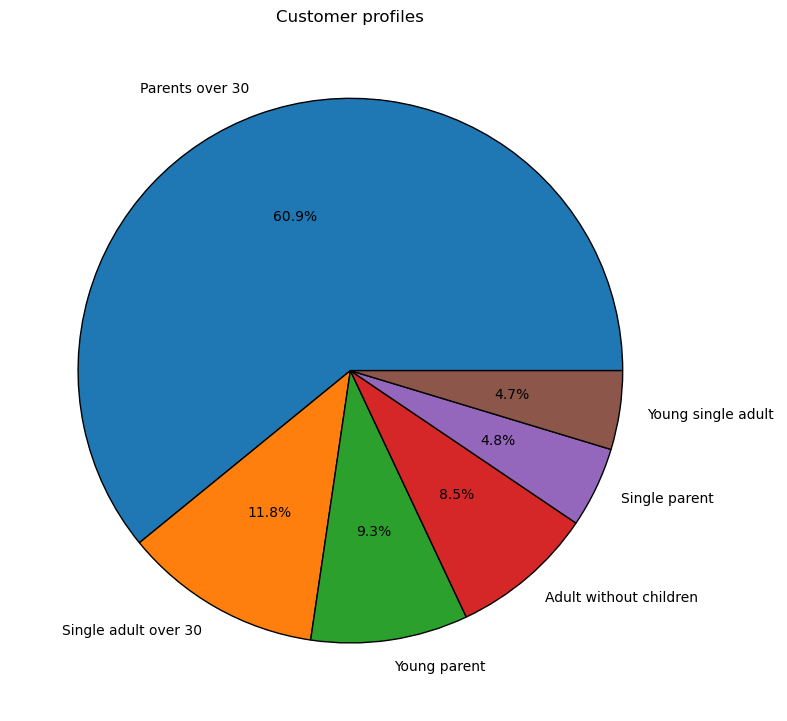

In [21]:
# Creating Pie Chart of customer profiles
profile_counts = df['customer_profile'].value_counts()
plt.figure(figsize = (8,8))
profiles_pie_chart = profile_counts.plot.pie(labels=('Parents over 30','Single adult over 30','Young parent', 'Adult without children', 'Single parent', 'Young single adult '), 
                          autopct = '%.1f%%',
                          wedgeprops = {'edgecolor':'black'})
plt.title('Customer profiles')
plt.ylabel('')
plt.tight_layout()
plt.show()

### Observations:
More than half of the products we sell are bought by parents over 30. Three quarters of our sales are made by parents (all types of parents combined) this is our main customer base. Marketing department can use this information to create programms to increase sales with single people, or offer discounts to parents (for example, on baby products) as loyalty rewards.

In [22]:
# Exporting Age Group Pie Chart Visualizations
profiles_pie_chart.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','profiles_distribution_pie_chart.png'))

## Profiling based on income

First, let's have a look at the income distribution.

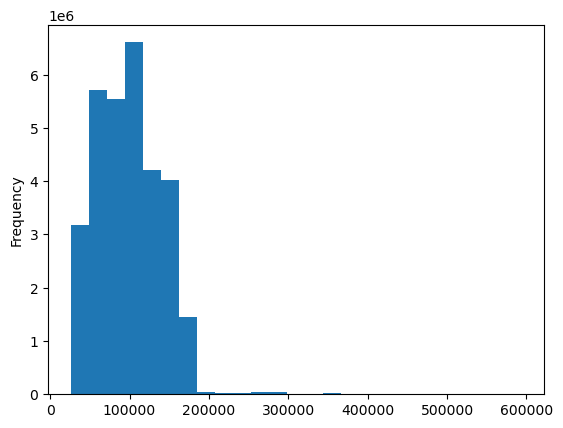

In [23]:
income_histogram = df['income'].plot.hist(bins=25)
plt.show()

There is a big drop after 180,000 USD.
Let's define thresholds for our economic groups. The values I find depend on the sources, but it is agreed that the middle calss income's lower bound is 50,000 USD, and its upper bound is 140,000USD. These will be our thresholds.

In [24]:
# Creating Low Income group 
df.loc[df['income']<=50000,'income_group']='Low Income'
# Creating Middle Income group
df.loc[(df['income']>50000)&(df['income']<=140000),'income_group']='Middle Income'
# Creating High Income group
df.loc[df['income']>140000,'income_group']='High Income'

In [25]:
# view results
df['income_group'].value_counts()

income_group
Middle Income    21961255
High Income       5640755
Low Income        3362554
Name: count, dtype: int64

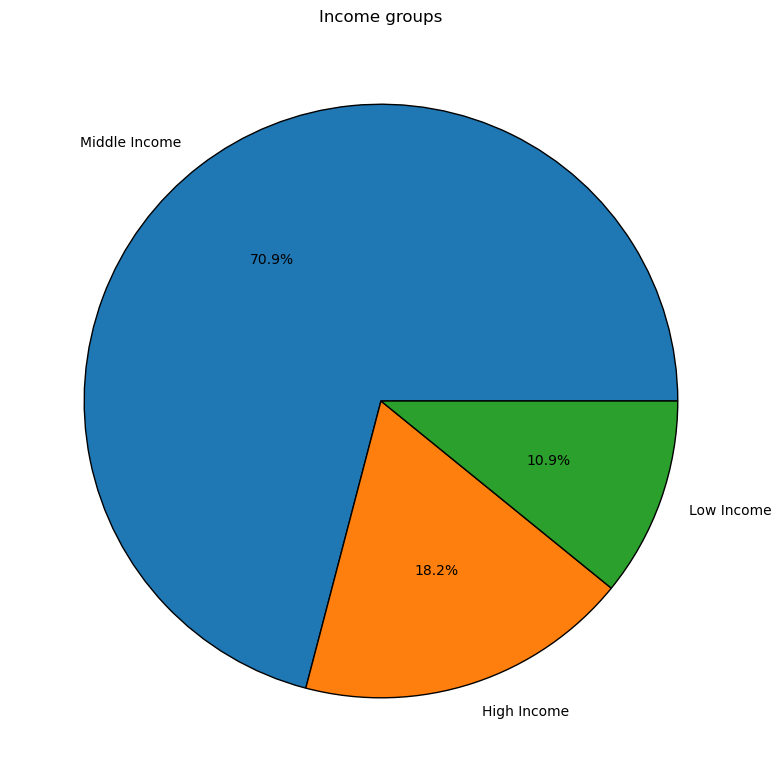

In [26]:
# Creating Pie Chart income groups
income_groups_counts = df['income_group'].value_counts()
plt.figure(figsize = (8,8))
income_groups_pie_chart = income_groups_counts.plot.pie(labels=('Middle Income','High Income','Low Income'), 
                          autopct = '%.1f%%',
                          wedgeprops = {'edgecolor':'black'})
plt.title('Income groups')
plt.ylabel('')
plt.tight_layout()
plt.show()

### Observations:
A vast majority of our sales are from middle income customers. 

In [27]:
# Exporting Age Group Pie Chart Visualization
income_groups_pie_chart.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','income_groups_pie_chart.png'))

## Descriptive stats based on customer profiles

### QUESTION: Is the number of days between orders influenced by the customer's family profile? income group? region?

In [28]:
# Customer family profile
df.groupby('customer_profile')['median_dspo'].agg(['mean', 'max', 'min'])

,mean,max,min
customer_profile,,,
Adult without children,9.874549,30.0,0.0
Parent over 30,9.978220,30.0,0.0
Single adult over 30,9.931305,30.0,0.0
Single parent,9.869971,30.0,0.0
Young parent,9.919357,30.0,0.0
Young single adult,10.063159,30.0,0.0


Looks like the answer is no. Min and Max are the same for all groups: let's plot the mean.

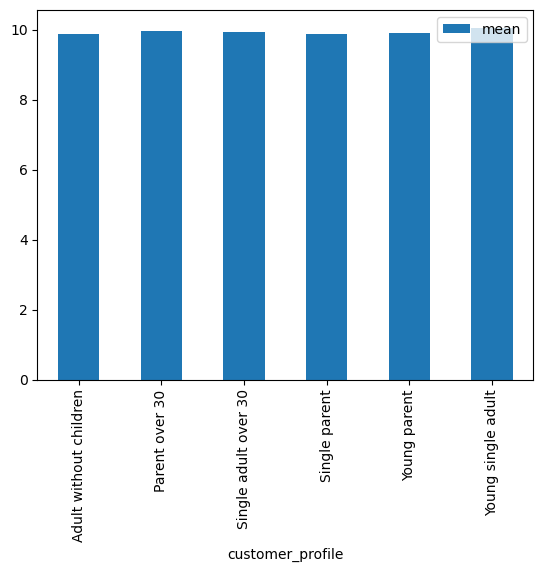

In [30]:
barchart_medial_dspo_profile = df.groupby('customer_profile')['median_dspo'].agg(['mean']).plot.bar()

In [31]:
# Exporting median dspo bar chart Visualization
barchart_medial_dspo_profile.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barchart_medial_dspo_profile'))

In [32]:
# Income group
df.groupby('income_group')['median_dspo'].agg(['mean', 'max', 'min'])

,mean,max,min
income_group,,,
High Income,9.840084,30.0,0.0
Low Income,10.519268,30.0,0.0
Middle Income,9.901137,30.0,0.0


Also no difference.

In [39]:
# Region
df.groupby('Region')['median_dspo'].agg(['mean', 'max', 'min'])

,mean,max,min
Region,,,
Midwest,10.019931,30.0,0.0
Northeast,9.924985,30.0,0.0
South,9.955835,30.0,0.0
West,9.923485,30.0,0.0


Also no difference.

### QUESTION: Is the hour of the day where orders are placed influenced by the customer's family profile? income group? region?

In [35]:
# Creation of a crosstab to answer the question about family's profile
crosstab = pd.crosstab(df['customer_profile'], df['busiest_period_of_day'], dropna = False)
crosstab.to_clipboard()
# Viz created on Excel - see report

In [36]:
# Creation of a crosstab to answer the question about income group
crosstab2 = pd.crosstab(df['income_group'], df['busiest_period_of_day'], dropna = False)
crosstab2.to_clipboard()
# Viz created on Excel - see report

In [41]:
# Creation of a crosstab to answer the question about region
crosstab3 = pd.crosstab(df['Region'], df['busiest_period_of_day'], dropna = False)
crosstab3.to_clipboard()
# Viz created on Excel - see report

### QUESTION: Is the type of goods (department_id) influenced by the customer's family profile? income group? region?

In [43]:
# Creation of a crosstab to answer the question about family's profile
crosstab4 = pd.crosstab(df['customer_profile'], df['department_id'], dropna = False)
crosstab4.to_clipboard()
# Viz created on Excel - see report

In [44]:
# Creation of a crosstab to answer the question about income group
crosstab5 = pd.crosstab(df['income_group'], df['department_id'], dropna = False)
crosstab5.to_clipboard()
# Viz created on Excel - see report

In [45]:
# Creation of a crosstab to answer the question about region
crosstab6 = pd.crosstab(df['Region'], df['department_id'], dropna = False)
crosstab6.to_clipboard()
# Viz created on Excel - see report

### QUESTION: Is the price of the products ordered influenced by the customer's family profile? income group? region?

In [47]:
# Creation of a crosstab to answer the question about family's profile
crosstab7 = pd.crosstab(df['customer_profile'], df['price_range_loc'], dropna = False)
crosstab7.to_clipboard()
# Viz created on Excel - see report

In [48]:
# Creation of a crosstab to answer the question about income group
crosstab5 = pd.crosstab(df['income_group'], df['price_range_loc'], dropna = False)
crosstab5.to_clipboard()
# Viz created on Excel - see report

In [49]:
# Creation of a crosstab to answer the question about region
crosstab6 = pd.crosstab(df['Region'], df['price_range_loc'], dropna = False)
crosstab6.to_clipboard()
# Viz created on Excel - see report

### QUESTION: Is the average total price of the orders influenced by the customer's family profile? income group? region?

In [5]:
def average_amount_spent_per_order(df):
    # Calculate the total amount spent per order
    order_totals = df.groupby('order_id')['prices'].sum().reset_index()
    order_totals.rename(columns={'prices': 'total_amount'}, inplace=True)

    # Merge the order totals back to the original DataFrame to get customer profiles
    df = df.merge(order_totals, on='order_id')

    # Calculate the average amount spent per order for each customer profile
    profile_avg_spent = df.groupby('customer_profile')['total_amount'].mean().reset_index()
    profile_avg_spent.rename(columns={'total_amount': 'average_amount_spent'}, inplace=True)

    return profile_avg_spent

# Get the average amount spent per order for each customer profile
result = average_amount_spent_per_order(df)

print(result)

MemoryError: Unable to allocate 3.23 GiB for an array with shape (14, 30964564) and data type int64

I'm getting a memory error again. I think this question would give some very relevant insight, so I'm going to create a 3rd part on another computer with more RAM tham this one tp be able to answer it. (this will be the only content of Part 3)